## Alzheimer's Diagnosis on MRI brain images
### in 4 different stages : Non Demented, Very Mild Demented, Mild Demented, and Moderate Demented.

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL

In [75]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMAGE_SIZE = [176,176]
EPOCHS = 10
# Verifying gpu
tf.test.gpu_device_name() 

'/device:GPU:0'

In [1]:
from google.colab import drive 
drive.mount('/mntDrive') 

Mounted at /mntDrive


In [5]:
train_path = "/mntDrive/My Drive/Colab Notebook/Alzheimers_Dataset/train"
CLASS_NAMES = os.listdir(train_path)

In [463]:
# Checking the distribution of classes in the dataset
for name in CLASS_NAMES:
  print(name, len(next(os.walk(train_path+f"/{name}"))[2]))

print("class names position for train set:",CLASS_NAMES)  

ModerateDemented 52
NonDemented 2560
MildDemented 717
VeryMildDemented 1792
class names position for train set: ['ModerateDemented', 'NonDemented', 'MildDemented', 'VeryMildDemented']


### Creating the train and validation sets :

In [458]:
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split = 0.2,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    subset = "training",
    seed = 42
)
valid_set = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split = 0.2,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    subset = "validation",
    seed = 42
)


Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


In [12]:
train_set.class_names = CLASS_NAMES
valid_set.class_names = CLASS_NAMES

CLASSES_NUM = len(CLASS_NAMES)

### How the dataset looks like :

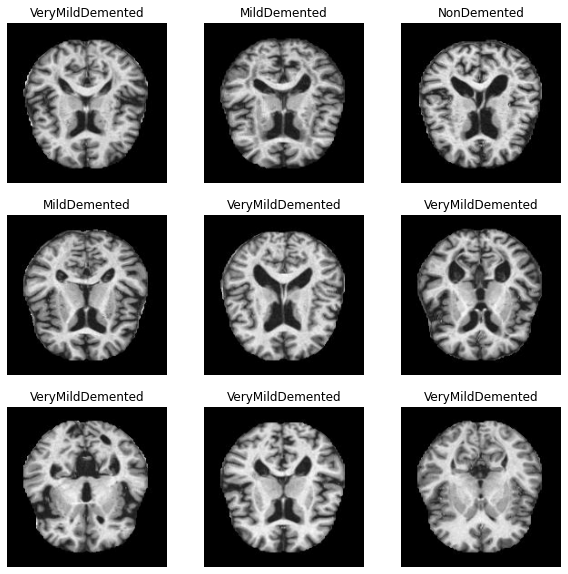

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_set.class_names[labels[i]])
    plt.axis("off")

In [14]:
# One hot encoding 
def one_hot_label(image, label):
    label = tf.one_hot(label, CLASSES_NUM)
    return image, label

train_set = train_set.map(one_hot_label, num_parallel_calls=AUTOTUNE)
valid_set = valid_set.map(one_hot_label, num_parallel_calls=AUTOTUNE)
# Efficient ordering of data for modeling.
train_set = train_set.cache().prefetch(buffer_size=AUTOTUNE)
valid_set = valid_set.cache().prefetch(buffer_size=AUTOTUNE)

### Building the model (With Inception ResNet V2 pretrained model)

In [82]:
res_net = tf.keras.applications.InceptionResNetV2(include_top=False, weights='imagenet',input_shape=(176,176,3))

In [83]:
Model = tf.keras.Sequential()
Model.add(res_net)
Model.add(tf.keras.layers.Flatten())
Model.add(tf.keras.layers.Dense(res_net.output.shape[3],activation='relu'))
Model.add(tf.keras.layers.Dropout(0.2))
Model.add(tf.keras.layers.Dense(4, activation="softmax"))

In [68]:
res_net.output.shape[3]

1536

In [70]:
Model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
flatten_6 (Flatten)          (None, 24576)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1536)              37750272  
_________________________________________________________________
dropout_5 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 6148      
Total params: 92,093,156
Trainable params: 92,032,612
Non-trainable params: 60,544
_________________________________________________________________


### Training and setting callbacks

In [81]:
from tensorflow.keras.callbacks import EarlyStopping
earlyStop_Max=EarlyStopping(monitor='val_auc', mode='max',verbose=1,patience=3,restore_best_weights=True)  
earlyStop_Min = EarlyStopping(monitor='val_loss', mode = 'min',verbose=1,patience=4,restore_best_weights=True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True,
                                                    monitor='val_auc',
                                                    mode='max')

#### Since the dataset is imbalanced (usually how medical data is), we will use the Area Under The Curve (AUC) metric.

In [84]:
Model.compile(optimizer='adam', loss = "categorical_crossentropy", metrics= tf.keras.metrics.AUC(name="auc"))

In [85]:
history = Model.fit(train_set, validation_data = valid_set, callbacks = [checkpoint_cb,earlyStop_Max,earlyStop_Min], epochs = EPOCHS)

Epoch 1/10
129/129 [==============================] - 133s 1s/step - loss: 3.2857 - auc: 0.7875 - val_loss: 43.7893 - val_auc: 0.7187
Epoch 2/10
129/129 [==============================] - 130s 1s/step - loss: 0.9215 - auc: 0.8661 - val_loss: 353.0478 - val_auc: 0.7307
Epoch 3/10
129/129 [==============================] - 129s 1s/step - loss: 0.5266 - auc: 0.9513 - val_loss: 0.6682 - val_auc: 0.9220
Epoch 4/10
129/129 [==============================] - 123s 954ms/step - loss: 0.2883 - auc: 0.9841 - val_loss: 1.1244 - val_auc: 0.8588
Epoch 5/10
129/129 [==============================] - 129s 1s/step - loss: 0.2094 - auc: 0.9909 - val_loss: 0.5752 - val_auc: 0.9566
Epoch 6/10
129/129 [==============================] - 123s 954ms/step - loss: 0.1226 - auc: 0.9961 - val_loss: 1.1866 - val_auc: 0.8872
Epoch 7/10
129/129 [==============================] - 123s 954ms/step - loss: 0.0858 - auc: 0.9975 - val_loss: 1.8880 - val_auc: 0.8676
Epoch 8/10
129/129 [==============================] - 131

Plotting the model's performance through training

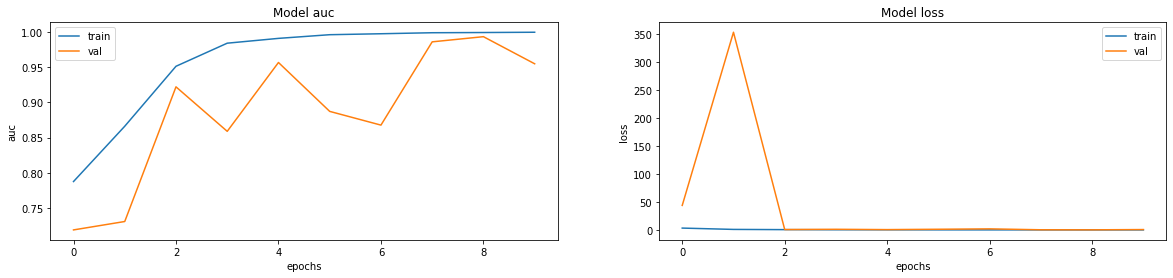

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(20, 4))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])  #the train metrics
    ax[i].plot(history.history['val_' + met]) #the validation set metrics
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

#### Loading the model with weights corresponding to the best epoch during training (epoch 8)

In [86]:
l_model = tf.keras.models.load_model("alzheimer_model.h5")

In [87]:
l_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
flatten_8 (Flatten)          (None, 24576)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 1536)              37750272  
_________________________________________________________________
dropout_7 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 6148      
Total params: 92,093,156
Trainable params: 92,032,612
Non-trainable params: 60,544
_________________________________________________________________


In [281]:
test_path = "/mntDrive/My Drive/Colab Notebook/Alzheimers_Dataset/test"
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size= (176,176)
)
test_set = test_set.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

Found 1279 files belonging to 4 classes.


In [96]:
Model.evaluate(test_set)

40/40 [==============================] - 569s 14s/step - loss: 2.9045 - auc: 0.7566


[2.904520273208618, 0.7566482424736023]

In [97]:
l_model.evaluate(test_set)

40/40 [==============================] - 11s 279ms/step - loss: 2.0765 - auc: 0.8714


[2.0765178203582764, 0.8713706731796265]

#### As we can see theres a big difference between epoch 10 (Model) and epoch 8 (l_model the loaded model) , overall AUC is 0.8714 which is great !

In [118]:
# Proccessing the data for further analysis
data = test_set.unbatch()
test_labels = list(label for image, label in data.as_numpy_iterator())
test_labels_top = [np.argmax(label) for label in test_labels]

In [112]:
predictions = l_model.predict(test_set)
print(len(test_labels_top),len(predictions))

1279 1279


In [114]:
!pip install scikit-plot

#### Visualizing the respective accuracy of the model for each class with AUC ROC graph 

(1279, 4)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


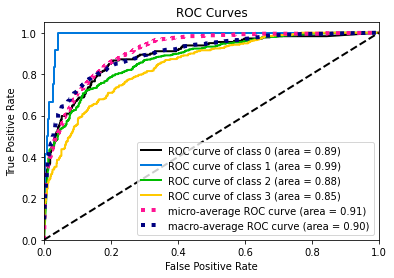

In [115]:
import scikitplot as skplt
import matplotlib.pyplot as plt

y_true = test_labels_top # ground truth labels
y_probas = predictions# predicted probabilities generated by sklearn classifier
print(y_probas.shape)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

Pretty high scores, class 1 has the highest score since the number of images it contributes to the dataset is very small compared to others.

### Visualizing the model accuracy with a Confusion Matrix

In [404]:
CLASS_NAMES_test = os.listdir("/mntDrive/My Drive/Colab Notebook/Alzheimers_Dataset/test")

In [133]:
import tensorflow as tf
confusion=tf.math.confusion_matrix(labels=test_labels_top,predictions=class_preds)

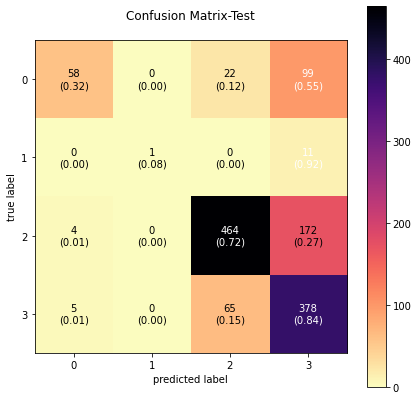

['MildDemented: 0', 'ModerateDemented: 1', 'NonDemented: 2', 'VeryMildDemented: 3']


In [393]:
from mlxtend.plotting import plot_confusion_matrix
plot_confusion_matrix(conf_mat=confusion.numpy(),figsize=(7,7) ,colorbar=True,cmap=plt.cm.magma_r,show_normed=True)
plt.title("Confusion Matrix-Test")
plt.show()
print([f"{name}: {CLASS_NAMES_test.index(name)}" for name in CLASS_NAMES_test])

I will attempt to create a Grad-Cam to visualize where the model looks at when predicting.

In [200]:
from glob import glob
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow import keras
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy as sp

Getting the model's activations and relevant layers:

In [141]:
res_net = l_model.get_layer(index = -5)

In [143]:
final_dense = l_model.get_layer(index = -1)
weights_dense = final_dense.get_weights()[0]

In [282]:
test_path = "/mntDrive/My Drive/Colab Notebook/Alzheimers_Dataset/test"
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size= (176,176)
)

Found 1279 files belonging to 4 classes.


The Grad-Cam heatmap for visualizing the ConvNet learning, is not working as well as i intended, but atleast i tried! next time i will get it better.

Theres also a representation of true and false predictions.

A function that will let us calculate the class activation map of the model:

In [409]:
def get_cam(fmaps,predict):
  w = weights_dense[:, predict]
  cam = fmaps.dot(w)
  cam = sp.ndimage.zoom(cam,(44,44),order=1)
  return cam

Plotting predictions with the heatmap :

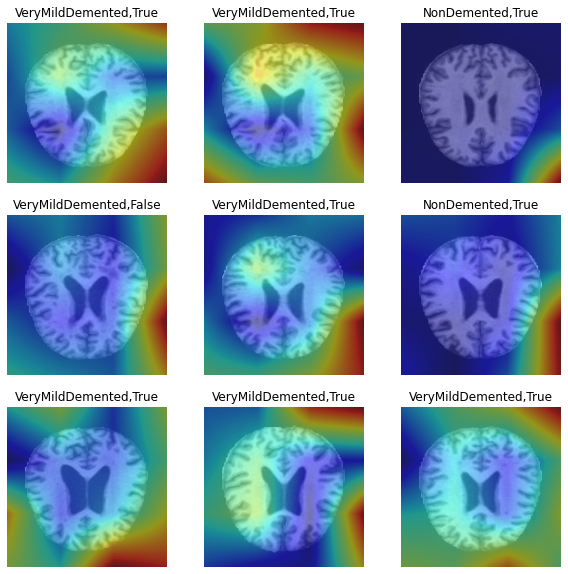

In [452]:
plt.figure(figsize=(10, 10))
for images, labels in test_take:
  for i in range(9):
    img = np.expand_dims(images[i],axis=0)
    fmaps = res_net.predict(img)[0]
    probs = l_model.predict(img)
    pred = np.argmax(probs)
    cam = get_cam(fmaps,pred)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img[0].astype("uint8"),alpha=0.8)
    plt.imshow(cam,cmap='jet',alpha=0.5)
    # plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(test_set.class_names[pred]+f",{pred == labels[i]}")
    plt.axis("off")

We can see some areas in the heatmaps , in certain predictions , where it concentrates on a single spot (middle picture for example).
Also for the NonDemented prediction, we can see that the heatmap is very weak and it refrains from the brain area in the image.